In [22]:
import glob
import os
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii
from astropy.table import Table, join
from astroquery.simbad import Simbad
import arviz as az

import pandas as pd    
from datetime import date
today=date.today()
DATE =today.strftime("%m_%d_%y")
print(DATE)
# from utils import *
from astropy import units as u
from astropy import constants as const
import pickle
from utils import *
import warnings
warnings.filterwarnings("ignore")
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage,AnchoredOffsetbox
from matplotlib import colors
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable


04_30_25


In [2]:
import pickle
import thejoker as tj
import pymc as pm
import corner
import arviz as az
plt.rcParams['figure.facecolor'] = 'white'
from matplotlib.gridspec import GridSpec
from astropy.time import Time


In [3]:
obj_113 = 7, 9, 11, 16, 18, 19, 21, 23  
obj_112 = 6, 7, 13, 23

In [4]:
p112_ver = {6: 2, 
             7: 1,
             13: 1, #another version exists
             23: 1,
            }

p113_ver = {7: 1,
             9: 1,
             10: 1,
             11: 2, #another version exists
             16: 2, #another version exists
             18: 1,
             19: 1,
             21: 1,
             23: 1,
            }

In [32]:
df_p112

,RG_id,galah_id,obj_name,Li_val,e_Li_val,vbroad,e_vbroad,fe_h,ruwe_dr2,Ba_fe,e_Ba_fe,La_fe,e_La_fe,Zr_fe,e_Zr_fe,Y_fe,e_Y_fe
0,1,150107004201104,UCAC4 297-057956,3.41,0.07,11.29,2.10,-0.28,0.89,0.32,0.05,0.11,0.05,-0.10,0.05,0.40,0.08
1,2,151230003202196,UCAC4 159-007674,2.10,0.12,11.37,2.20,-0.28,0.96,0.24,0.10,0.13,0.08,0.03,0.10,0.10,0.18
2,4,161013005401317,TYC 763-2824-1,2.68,0.09,8.79,2.15,-0.47,0.93,0.47,0.06,0.13,0.06,-0.01,0.11,-0.05,0.09
3,5,161104004801189,UCAC4 374-013344,2.96,0.11,7.49,2.19,-0.64,0.99,0.26,0.09,0.06,0.08,-0.01,0.15,0.05,0.13
4,6,150829004301285,UCAC4 250-188426,1.79,0.14,7.95,2.29,-0.42,1.03,0.07,0.13,0.03,0.22,NaN,NaN,-0.03,0.19
5,7,160129003601260,UCAC4 314-010619,2.60,0.13,10.03,2.25,-0.21,1.00,0.63,0.11,0.23,0.13,NaN,NaN,0.23,0.16
6,13,190212001601338,2MASS J05354326-0034367,3.34,0.08,19.17,2.16,-0.00,0.93,0.14,0.06,0.44,0.10,NaN,NaN,0.08,0.09
7,14,140311007101261,UCAC4 220-051792,3.24,0.11,15.26,2.20,0.00,1.02,0.52,0.09,0.29,0.17,NaN,NaN,-0.02,0.15
8,23,170514002101318,CD-69 769,1.86,0.12,13.34,2.23,0.06,1.04,0.40,0.09,NaN,NaN,0.40,0.14,0.50,0.14


In [5]:
df_p112 = pd.read_csv('df_p112.csv')
df_p113 = pd.read_csv('df_p113.csv')


In [6]:
def get_stats(binaries, program, ver):
    stat_dict = {}
    for i,RG in enumerate(binaries):
        version = ver[RG]
        print(RG)
        fname = '../mcmc/%s/%s_trace_%s.pickle'%(program,RG,version)
        with open(fname, 'rb') as handle:
            trace = pickle.load(handle)
        colnames = ['P','e','K','v0']
        summary = az.summary(trace, colnames)
        rhat = summary['r_hat'].to_list() 
        
        stat_dict[i] = [RG, summary['mean']['P'], summary['sd']['P'], 
                        summary['mean']['e'], summary['sd']['e'], 
                        summary['mean']['K'], summary['sd']['K'],
                        summary['r_hat']['P'], summary['r_hat']['e'],
                        ]
    df = pd.DataFrame(stat_dict)
    df = df.T
    df.columns = ['RG_id','P','err_P','e','err_e','K','err_K','r_hat_P','r_hat_e']
    if '112' in program:
        df1 = df_p112
    elif '113' in program:
        df1 = df_p113
    df = pd.merge(df, df1, on='RG_id')
    if '112' in program:
        df['program'] = [112]*len(df)
    else:
        df['program'] = [113]*len(df)
    return df

stat_dict_112 = get_stats(obj_112, 'p112', p112_ver)
stat_dict_113 = get_stats(obj_113, 'p113', p113_ver)

data0 = pd.concat([stat_dict_112,stat_dict_113]).reset_index()



6
7
13
23
7
9
11
16
18
19
21
23


In [40]:
data[data.program==113][['RG_id','P','e']]

,RG_id,P,e
4,7.0,62.897,0.740
5,9.0,20.694,0.181
6,11.0,49.811,0.547
7,16.0,33.953,0.797
8,18.0,41.465,0.320
9,19.0,52.021,0.408
10,21.0,26.592,0.636
11,23.0,74.873,0.689


In [39]:
data[data.program==112][['RG_id','P','e']]
# data

,RG_id,P,e
0,6.0,36.458,0.201
1,7.0,26.844,0.234
2,13.0,86.541,0.266
3,23.0,42.065,0.177


In [7]:
galah = Table.read('../../lithium/data/GALAH_DR3_main_allstar_v2.fits').to_pandas()

In [8]:
merged_113 = pd.read_csv('merged_113.csv')
merged_112 = pd.read_csv('merged_112.csv')

In [9]:
   
with open('obj_dir_p112.pkl', 'rb') as f:
    obj_dir_p112 = pickle.load(f)
    
with open('obj_dir_p113.pkl', 'rb') as f:
    obj_dir_p113 = pickle.load(f)

In [10]:
galah_vac = Table.read('../../lithium/data/GALAH_DR3_VAC_ages_v2.fits').to_pandas()

In [11]:
data = pd.merge(data0, galah_vac[['sobject_id','m_act_bstep','e_m_act_bstep']], left_on='galah_id', right_on='sobject_id')

In [17]:
data.keys()

Index(['index', 'RG_id', 'P', 'err_P', 'e', 'err_e', 'K', 'err_K', 'r_hat_P',
       'r_hat_e', 'galah_id', 'obj_name', 'Li_val', 'e_Li_val', 'vbroad',
       'e_vbroad', 'fe_h', 'ruwe_dr2', 'Ba_fe', 'e_Ba_fe', 'La_fe', 'e_La_fe',
       'Zr_fe', 'e_Zr_fe', 'Y_fe', 'e_Y_fe', 'program', 'sobject_id',
       'm_act_bstep', 'e_m_act_bstep'],
      dtype='object')

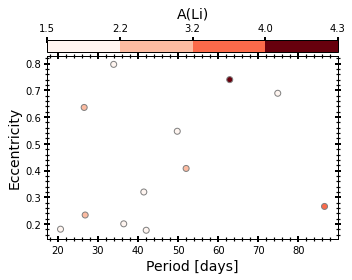

In [31]:
bounds = [1.5, 2.2, 3.2, 4, 4.3]
cmap_color = 'Reds'
cmap = plt.get_cmap(cmap_color, len(bounds))
norm = colors.BoundaryNorm(bounds, cmap.N)
clabel = 'A(Li)'

fig=plt.figure(figsize=(5,4))
ax1=plt.subplot(111)
im1=plt.scatter(data.P, data.e, c=data.Li_val,cmap=cmap, norm=norm,ec='grey')
plt.xlabel('Period [days]')
plt.ylabel('Eccentricity')

ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
cb1 = fig.colorbar(im1, cax=cax1, orientation="horizontal", boundaries=bounds, ticks=bounds)
cax1.xaxis.set_ticks_position("top") # change tick position to top
cb1.ax.set_title(clabel)
plt.tight_layout()
# plt.savefig('../plots/P_e_Li_%s.png'%DATE,bbox_inches='tight',dpi=200)

In [12]:
def msini_func(K, P, e, Mstar):
    '''
    Get Mp sin(i), the minimum mass of the companion.
    @input:
        K: semi-amplitude in km/s
        P: period in days
        e: eccentricity
        M: mass of the star in solar masses
    
    '''
    from scipy import optimize
    
    # convert units to SI units
    K = (K*(u.km/u.second)).to(u.meter/u.second)
    P = (P*u.day).to(u.second)
    Mstar = (Mstar*u.M_sun).to(u.kg)
    e = e*u.dimensionless_unscaled
    
    # define constants
    pi = np.pi
    G  = const.G
    
    # if Mp << Mstar:
    Msini = (Mstar)**(2./3.) * np.sqrt(1-e**2.) * K * (P/(2*pi*G))**(1./3.)
    
    # else:
    a = np.sqrt(1-e**2.) * K * (P/(2*pi*G))**(1./3.)
    #Msini = (Mstar+Mp)**(2./3.) * a
    #fx = (Mstar+Mp)**(2./3.) * a - Msini
    
    Mjup = u.M_jup.to(u.kg)
    Msun = u.Msun.to(u.kg)
    #print(Mjup)
    def func(x, a, Mstar):
        return x - (Mstar + x)**(2./3.) * a # x = Msini

    from scipy.optimize import brentq, bisect, fsolve
    from scipy.optimize import fsolve

    sol   = optimize.root(func, Msun, args=(a.value, Mstar.value) )
    Msini = sol.x
    
    #root  = brentq(func, 0.1, Msun , args=(a.value, Mstar.value))
    
    return Msini, sol.success


In [13]:
for i, row in data.iterrows():
#     if i != 1: continue
    K, P, e, Mstar = row['K'], row['P'], row['e'], row['m_act_bstep']
    K = abs(K)
    Msini, success = msini_func(K, P, e, Mstar)
    Msini_jup   = Msini/u.M_jup.to(u.kg)
    Msini_solar = Msini/u.Msun.to(u.kg)

    if success:
        if i != 5: continue
        print(K, P, e, Mstar)
        print(i,'%.2f Mstar \t %.3f Mjup \t %.3f Msun' % (Mstar, Msini_jup, Msini_solar))

0.035 20.694 0.181 0.9565468227493464
5 0.96 Mstar 	 0.452 Mjup 	 0.000 Msun


In [14]:
p112_d = {6:{'Mjup':None, 'Msol': None}, 7:{'Mjup':None, 'Msol': None},
          13:{'Mjup':None, 'Msol': None}, 23:{'Mjup':None, 'Msol': None}
         }
p113_d = {7:{'Mjup':None, 'Msol': None}, 9:{'Mjup':None, 'Msol': None},
          11:{'Mjup':None, 'Msol': None}, 16:{'Mjup':None, 'Msol': None},
          18:{'Mjup':None, 'Msol': None}, 19:{'Mjup':None, 'Msol': None},
          21:{'Mjup':None, 'Msol': None}, 23:{'Mjup':None, 'Msol': None}
         }

def get_msini(objects, program, version, savedict):
    for RG in objects:
        fname1 = '../mcmc/%s/%s_mcmc_%s.pickle'%(program,RG,version)
        with open(fname1, 'rb') as handle:
            mcmc_samples = pickle.load(handle)
        colnames = ['P','e','K','v0']

        Ks = mcmc_samples['K'].value
        Ps = mcmc_samples['P'].value
        es = mcmc_samples['e'].value
        Mjup = []
        Msol = []
        Mstar = np.array(data[(data.RG_id==RG) & (data.program == int(program[1:]))].m_act_bstep)[0]
        
        if str(Mstar) == 'nan':
            dtemp = data[(data.RG_id==RG) & (data.program == int(program[1:]))]
            if dtemp.sobject_id.values[0] == 190212001601338: # gaia DR3 3217773074208416640
                Mstar = 1.070
        for i in range(len(Ks)):
            K, P, e = Ks[i], Ps[i], es[i]
            Msini, success = msini_func(K, P, e, Mstar)
            Msini_jup   = Msini/u.M_jup.to(u.kg)
            Msini_solar = Msini/u.Msun.to(u.kg)
            Mjup.append(Msini_jup[0])
            Msol.append(Msini_solar[0])
        savedict[RG]['Mjup'] = Mjup
        savedict[RG]['Msol'] = Msol
        # Msini_jup   = Msini/u.M_jup.to(u.kg)
        # Msini_solar = Msini/u.Msun.to(u.kg)
    return savedict

p112_msini = get_msini(obj_112, 'p112', 1, p112_d)
p113_msini = get_msini(obj_113, 'p113', 1, p113_d)

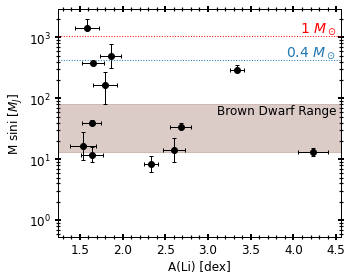

In [212]:
def msini_li(msini,df,unit='Mjup',legend=False):
    PLOT_PARAMS(LS=12, SIZE=12)
    for k, v in msini.items():
        data = np.array(msini[k][unit])
        p16 = np.percentile(data, 16)
        p84 = np.percentile(data, 84)
        p50 = np.percentile(data, 50)
        mass_min = min(data)
        mass_max = max(data)
        yerr=[[p50-p16], [p84-p50]]
        plt.errorbar(df[df.RG_id == k].Li_val, p50, xerr=df[df.RG_id == k].e_Li_val, yerr=yerr,fmt='o',capsize=2,lw=1,mec='k',mfc='k',color='k')
        plt.yscale('log')
        plt.ylabel('M sini [$M_J$]')
        plt.xlabel('A(Li) [dex]')
    
    mearth = (u.Mjup).to(u.Mearth)
    msolar = (u.Msun).to(u.Mjup)
    
    if legend:
        xi = 4.5
        plt.axhline(msolar,c='r',ls='dotted',lw=1,label='1 $M_\odot$')
        plt.text(xi, msolar, s='1 $M_\odot$', ha='right',va='bottom', c='r',fontsize=14)

        plt.axhline(0.4*msolar,c='C0',ls='dotted',lw=1, label='0.4 $M_\odot$')
        plt.text(xi, 0.4*msolar, s='0.4 $M_\odot$', ha='right',va='bottom', c='C0',fontsize=14)

        #plt.axhline(mearth,c='C1',ls='dotted',lw=1,label='1 $M_\oplus$')
        #plt.text(4.5, mearth, s='1 $M_\oplus$', ha='right',va='top', c='C1',fontsize=14)

        plt.axhspan(13, 80, color='tab:brown', alpha=0.3, label='Brown Dwarf')
        plt.text(xi, 80, s='Brown Dwarf Range', ha='right',va='top', c='k',fontsize=12)
        #plt.legend()
    

plt.figure(figsize=(5,4))
msini_li(p112_msini, df_p112,legend=True)
msini_li(p113_msini, df_p113)
plt.tight_layout()
# plt.savefig('../plots/msini_%s.png'%DATE,bbox_inches='tight',dpi=200)

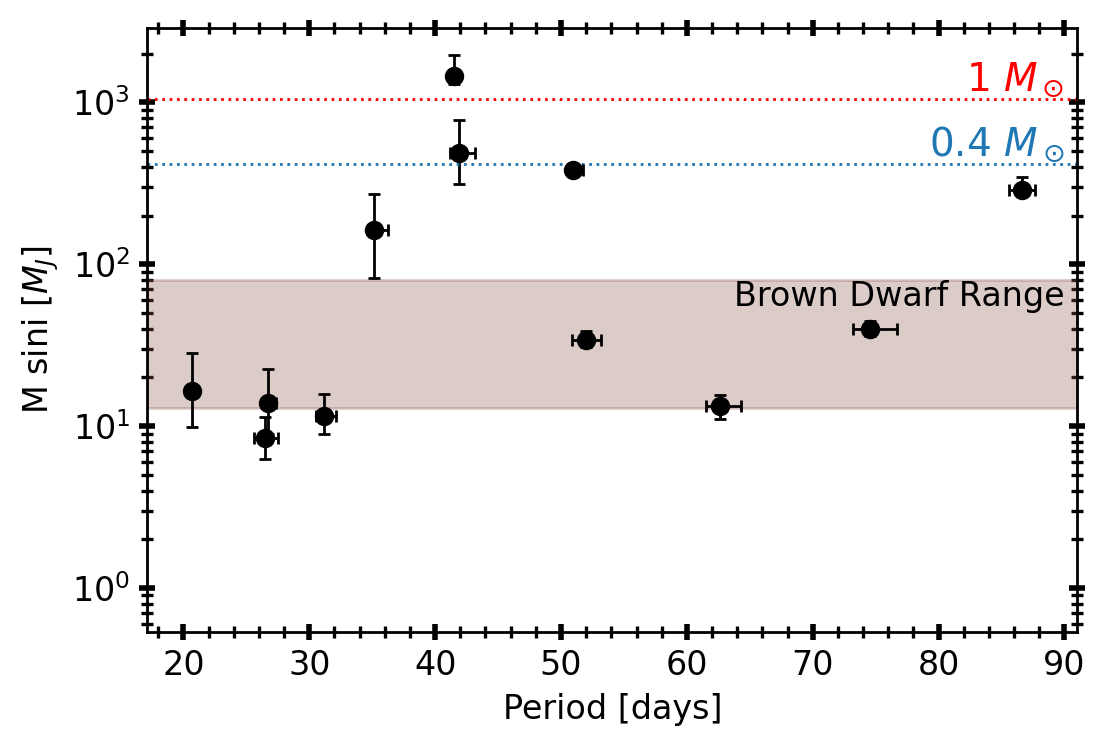

In [210]:
def msini_period(msini,df,unit='Mjup',legend=False):
    PLOT_PARAMS(LS=12, SIZE=12)
    for k, v in msini.items():
        data = np.array(msini[k][unit])
        m16 = np.percentile(data, 16)
        m84 = np.percentile(data, 84)
        m50 = np.percentile(data, 50)
        mass_min = min(data)
        mass_max = max(data)
        yerr=[[m50-m16], [m84-m50]]
        p16, p50, p84 = df[df.RG_id == k][['P16','P50','P84']].values[0]
        xerr=[[p50-p16], [p84-p50]]
        plt.errorbar(df[df.RG_id == k].P50, m50, xerr=xerr, yerr=yerr,fmt='o',capsize=2,lw=1,mec='k',mfc='k',color='k')
        plt.yscale('log')
        plt.ylabel('M sini [$M_J$]')
        plt.xlabel('Period [days]')
    msolar = (u.Msun).to(u.Mjup)
    if legend:
        xi = 90
        plt.axhline(msolar,c='r',ls='dotted',lw=1,label='1 $M_\odot$')
        plt.text(xi, msolar, s='1 $M_\odot$', ha='right',va='bottom', c='r',fontsize=14)

        plt.axhline(0.4*msolar,c='C0',ls='dotted',lw=1, label='0.4 $M_\odot$')
        plt.text(xi, 0.4*msolar, s='0.4 $M_\odot$', ha='right',va='bottom', c='C0',fontsize=14)

        #plt.axhline(mearth,c='C1',ls='dotted',lw=1,label='1 $M_\oplus$')
        #plt.text(4.5, mearth, s='1 $M_\oplus$', ha='right',va='top', c='C1',fontsize=14)

        plt.axhspan(13, 80, color='tab:brown', alpha=0.3, label='Brown Dwarf')
        plt.text(xi, 80, s='Brown Dwarf Range', ha='right',va='top', c='k',fontsize=12)
        #plt.legend()
plt.figure(dpi=200)
msini_period(p112_msini, p112_P_e[0],legend=True)  
msini_period(p113_msini, p113_P_e[0])  
# plt.savefig('../plots/msini_period_%s.png'%DATE,bbox_inches='tight',dpi=200)

In [67]:
data.keys()

Index(['index', 'RG_id', 'P', 'err_P', 'e', 'err_e', 'K', 'err_K', 'r_hat_P',
       'r_hat_e', 'galah_id', 'obj_name', 'Li_val', 'e_Li_val', 'vbroad',
       'e_vbroad', 'fe_h', 'ruwe_dr2', 'Ba_fe', 'e_Ba_fe', 'La_fe', 'e_La_fe',
       'Zr_fe', 'e_Zr_fe', 'Y_fe', 'e_Y_fe', 'program', 'sobject_id',
       'm_act_bstep', 'e_m_act_bstep'],
      dtype='object')

In [65]:
p112_d.keys()

dict_keys([6, 7, 13, 23])

In [102]:
p113_P_e[1]

,RG_id,P16,P50,P84
0,7,0.678439,0.741348,0.803705
1,9,0.040042,0.153700,0.310820
2,11,0.053435,0.196656,0.404433
3,16,0.513749,0.533830,0.569494
4,18,0.268029,0.294007,0.381344
5,19,0.323295,0.393679,0.497483
6,21,0.496850,0.645471,0.775307
7,23,0.632177,0.692342,0.745996


[1.54 1.58 1.64 1.64 1.65 1.79 1.86 2.33 2.6  2.68 3.34 4.23]


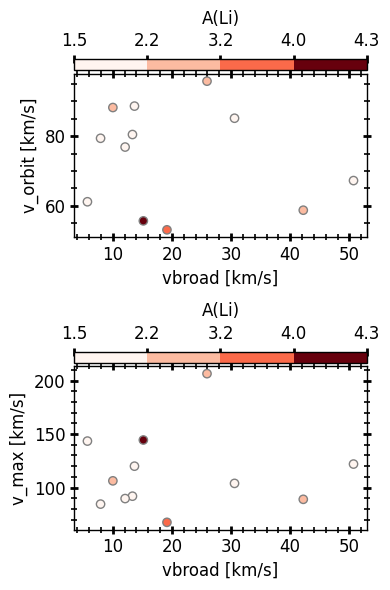

[0.06321674 0.1328527  0.1536995  0.18421337 0.1966564  0.23642415
 0.29400656 0.39367889 0.53383003 0.64547072 0.69234192 0.74134791]


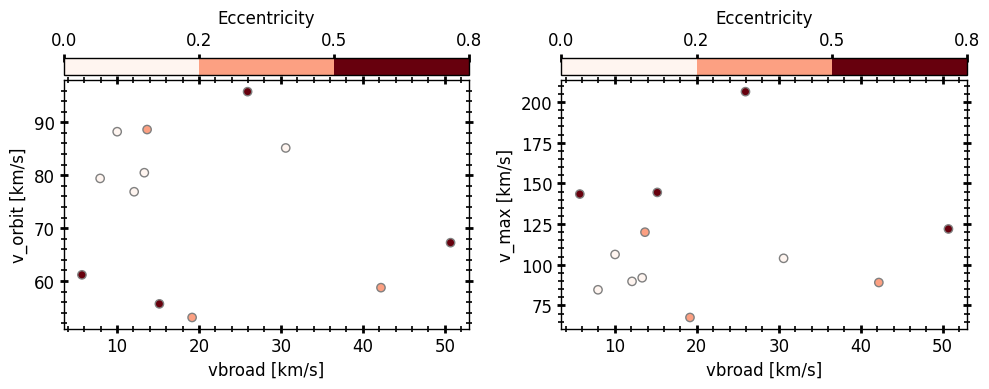

[20.694 26.592 26.844 33.953 36.458 41.465 42.065 49.811 52.021 62.897
 74.873 86.541]


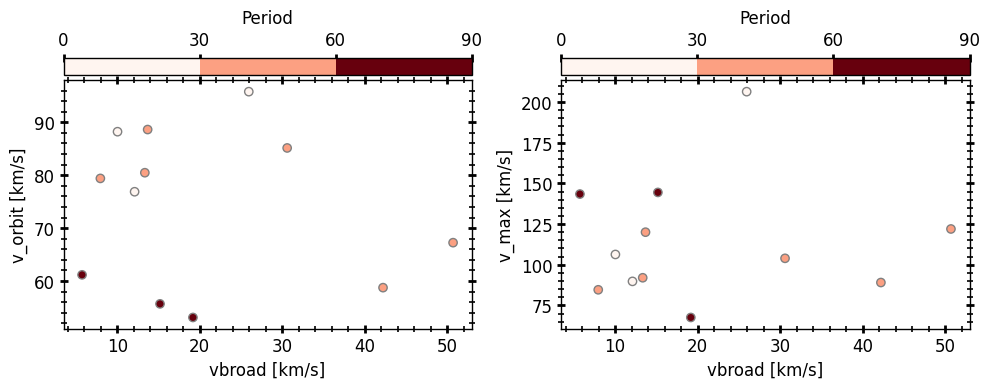

In [266]:
def semi_major_axis(M1, M2, P):
    '''
    M1 : in solar masses
    P : in days
    M2 : in Mjup
    
    '''
    G = const.G
    M1 = (M1*u.Msun).to(u.kg)
    M2 = (M2*u.Mjup).to(u.kg)
    M = (M1+M2)
    P = (P*u.day).to(u.second)
    a = (G*M*P**2/(4*np.pi**2))**(1./3)
    
    return a
    
def func(msini, P_df, e_df, program, data_df, unit='Mjup'):
    program = int(program[1:])
    new_dict = {'RG_id' : [], 'M_1': [], 'M_2': [], 'P': [], 'a': [], 'e': [], 'program': []}
    for k, v in msini.items():
        data = np.array(msini[k][unit])
        m16 = np.percentile(data, 16)
        m84 = np.percentile(data, 84)
        m50 = np.percentile(data, 50)
        p16, p50, p84 = P_df[P_df.RG_id == k][['P16','P50','P84']].values[0]
        e16, e50, e84 = e_df[e_df.RG_id == k][['P16','P50','P84']].values[0]
        dtemp = data_df[(data_df.RG_id==k) & (data_df.program==program)]
        if dtemp.sobject_id.values[0] == 190212001601338: # gaia DR3 3217773074208416640
            Mstar = 1.070
        else:
            Mstar = dtemp.m_act_bstep.values[0]
        
        period = p50*1
        M1     = Mstar*1
        M2     = m50*1
        a = semi_major_axis(M1, M2, period)
        new_dict['RG_id'].append(k)
        new_dict['program'].append(program)
        new_dict['M_1'].append((M1*u.Msun).to(u.kg))
        new_dict['M_2'].append((M2*u.Mjup).to(u.kg))
        new_dict['P'].append((period*u.day).to(u.second))
        new_dict['a'].append(a)
        new_dict['e'].append(e50)
        
    new_df = pd.DataFrame(new_dict)
    return new_df

a_112 = func(p112_msini, p112_P_e[0], p112_P_e[1], 'p112', data)
a_113 = func(p113_msini, p113_P_e[0], p113_P_e[1], 'p113', data)
a_all = pd.concat([a_112, a_113])

def v_orb(df):
    '''
    a: in meters
    P: in days
    
    v_orb : in m/s
    '''
    #a = a*u.m
    #P = P*u.day.to(u.second)
    a = a_all.a.to_numpy()
    P = a_all.P.to_numpy()
    v = 2*np.pi*a/P
    df['v_orb'] = v
    return df

a_all = v_orb(a_all)

def v_max(df):
    M_1, M_2 = df.M_1.to_numpy(), df.M_2.to_numpy()
    M = (M_1+M_2)
    a = df.a.to_numpy()
    e = df.e.to_numpy()
    G = const.G

    v = ((G*M/a) * (2./(1-e) - 1))
    v = [np.sqrt(i.value) for i in v]
    v = [i*u.m/u.s for i in v]
    df['v_max'] = v
    return df

a_all = v_max(a_all)
a_all_p112 = pd.merge(a_all[a_all.program==112], data[data.program==112], on='RG_id')
a_all_p113 = pd.merge(a_all[a_all.program==113], data[data.program==113], on='RG_id')
a_all = pd.concat([a_all_p112, a_all_p113])

# ================================ Li-VAL ================================

# a_all.v_max.to_numpy()[0].to(u.km/u.hour)
bounds = [1.5, 2.2, 3.2, 4, 4.3]
cmap_color = 'Reds'
cmap = plt.get_cmap(cmap_color, len(bounds))
norm = colors.BoundaryNorm(bounds, cmap.N)
clabel = 'A(Li)'

plt.figure(figsize=(4,6),dpi=100)
ax1=plt.subplot(211)
im1=plt.scatter(a_all.vbroad, [i.to(u.km/u.second).value for i in a_all.v_orb.to_numpy()], c=a_all.Li_val, cmap=cmap, norm=norm,ec='grey')
plt.xlabel('vbroad [km/s]')
plt.ylabel('v_orbit [km/s]')

ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
cb1 = fig.colorbar(im1, cax=cax1, orientation="horizontal", boundaries=bounds, ticks=bounds)
cax1.xaxis.set_ticks_position("top") # change tick position to top
cb1.ax.set_title(clabel)

ax2=plt.subplot(212)
im2=plt.scatter(a_all.vbroad, [i.to(u.km/u.second).value for i in a_all.v_max.to_numpy()], c=a_all.Li_val, cmap=cmap, norm=norm,ec='grey')
plt.xlabel('vbroad [km/s]')
plt.ylabel('v_max [km/s]')

ax2_divider = make_axes_locatable(ax2)
cax2 = ax2_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
cb2 = fig.colorbar(im2, cax=cax2, orientation="horizontal", boundaries=bounds, ticks=bounds)
cax2.xaxis.set_ticks_position("top") # change tick position to top
cb2.ax.set_title(clabel)


print(np.sort(a_all.Li_val.tolist()))

plt.tight_layout()
# plt.savefig('../plots/vbroad_vmax_vorb_%s.png'%DATE,bbox_inches='tight',dpi=200)
plt.show()

In [202]:
data.keys()

Index(['index', 'RG_id', 'P', 'err_P', 'e', 'err_e', 'K', 'err_K', 'r_hat_P',
       'r_hat_e', 'galah_id', 'obj_name', 'Li_val', 'e_Li_val', 'vbroad',
       'e_vbroad', 'fe_h', 'ruwe_dr2', 'Ba_fe', 'e_Ba_fe', 'La_fe', 'e_La_fe',
       'Zr_fe', 'e_Zr_fe', 'Y_fe', 'e_Y_fe', 'program', 'sobject_id',
       'm_act_bstep', 'e_m_act_bstep'],
      dtype='object')

In [251]:
a_all.keys()
a_all.P_y

0    36.458
1    26.844
2    86.541
3    42.065
0    62.897
1    20.694
2    49.811
3    33.953
4    41.465
5    52.021
6    26.592
7    74.873
Name: P_y, dtype: float64

In [163]:
type(1*u.m/u.s)

astropy.units.quantity.Quantity

In [150]:
df_p112

,RG_id,galah_id,obj_name,Li_val,e_Li_val,vbroad,e_vbroad,fe_h,ruwe_dr2,Ba_fe,e_Ba_fe,La_fe,e_La_fe,Zr_fe,e_Zr_fe,Y_fe,e_Y_fe
0,1,150107004201104,UCAC4 297-057956,3.41,0.07,11.29,2.10,-0.28,0.89,0.32,0.05,0.11,0.05,-0.10,0.05,0.40,0.08
1,2,151230003202196,UCAC4 159-007674,2.10,0.12,11.37,2.20,-0.28,0.96,0.24,0.10,0.13,0.08,0.03,0.10,0.10,0.18
2,4,161013005401317,TYC 763-2824-1,2.68,0.09,8.79,2.15,-0.47,0.93,0.47,0.06,0.13,0.06,-0.01,0.11,-0.05,0.09
3,5,161104004801189,UCAC4 374-013344,2.96,0.11,7.49,2.19,-0.64,0.99,0.26,0.09,0.06,0.08,-0.01,0.15,0.05,0.13
4,6,150829004301285,UCAC4 250-188426,1.79,0.14,7.95,2.29,-0.42,1.03,0.07,0.13,0.03,0.22,NaN,NaN,-0.03,0.19
5,7,160129003601260,UCAC4 314-010619,2.60,0.13,10.03,2.25,-0.21,1.00,0.63,0.11,0.23,0.13,NaN,NaN,0.23,0.16
6,13,190212001601338,2MASS J05354326-0034367,3.34,0.08,19.17,2.16,-0.00,0.93,0.14,0.06,0.44,0.10,NaN,NaN,0.08,0.09
7,14,140311007101261,UCAC4 220-051792,3.24,0.11,15.26,2.20,0.00,1.02,0.52,0.09,0.29,0.17,NaN,NaN,-0.02,0.15
8,23,170514002101318,CD-69 769,1.86,0.12,13.34,2.23,0.06,1.04,0.40,0.09,NaN,NaN,0.40,0.14,0.50,0.14


In [122]:
const.G*(1*u.kg)/(10*u.m)

<Quantity 6.6743e-12 m2 / s2>

In [113]:
a_all

,RG_id,M_1,M_2,P,a,e,v_orb
0,6,3.315110704148841e+30 kg,3.109983914622319e+29 kg,3038618.3754768297 s,38395446668.55724 m,0.063217,79393.22302446724 m / s
1,7,3.755732909242717e+30 kg,2.6485364681053047e+28 kg,2309403.746228181 s,32428791852.91599 m,0.184213,88228.88108353084 m / s
2,13,2.1275985616469148e+30 kg,5.437795649184811e+29 kg,7484546.961618691 s,63246640617.561554 m,0.236424,53094.77849421983 m / s
3,23,3.5718163025518066e+30 kg,9.279159804379865e+29 kg,3621051.3538176185 s,46376789095.302704 m,0.132853,80472.19753748045 m / s
0,7,2.201007297125024e+30 kg,2.5159974149071126e+28 kg,5411309.792175493 s,47944212752.89068 m,0.741348,55669.0311038628 m / s
1,9,1.9020071441396594e+30 kg,3.14275736966928e+28 kg,1784886.7756704045 s,21837300368.78682 m,0.153700,76871.99361656616 m / s
2,11,3.947149677242996e+30 kg,2.1993560548841535e+28 kg,2695724.2837587087 s,36534056848.47536 m,0.196656,85153.45971581968 m / s
3,16,2.4720811858848383e+30 kg,7.207186465239522e+29 kg,4403854.215323156 s,47129682651.77362 m,0.533830,67242.12816566431 m / s
4,18,3.20334337150246e+30 kg,2.745724934126608e+30 kg,3582660.3215607763 s,50540019293.001625 m,0.294007,88635.89571562281 m / s
5,19,2.1040517355014979e+30 kg,6.460786379686747e+28 kg,4488336.878112315 s,41956838485.040535 m,0.393679,58735.02775392985 m / s


In [16]:
def msini_stats(dic, unit):
    for k, v in dic.items():
        print(k)
        data = np.array(dic[k][unit])
        p16 = np.percentile(data, 16)
        p84 = np.percentile(data, 84)
        p50 = np.percentile(data, 50)
        label = 'RG%i : %.2f (%.2f, %.2f)'%(k, p50, p16, p84)
        _ = plt.hist(data,bins='auto',label=label)
        plt.legend()

# msini_stats(p112_msini,'Msol')
# msini_stats(p113_msini,'Msol')

In [17]:
def plot_samples(program, RG, version, obj_dir, ax):
    
    fname = '../mcmc/%s/%s_joker_%s.hdf5'%(program,RG,version)
    joker_samples = tj.JokerSamples.read(fname)
    t, rv, rv_err = np.array(obj_dir[RG]['time']), np.array(obj_dir[RG]['rv']), np.array(obj_dir[RG]['err'])
    mask = (rv >= -100)
    t, rv, rv_err = t[mask], rv[mask], rv_err[mask]

    data = Table()
    data['bjd']     = t
    data['rv']      = rv
    data['rv_err']  = rv_err
    data["rv"].unit = u.km / u.s
    data["rv_err"].unit = u.km / u.s
    
    data = tj.RVData(
        t=Time(data["bjd"], format="jd", scale="tcb"),
        rv=u.Quantity(data["rv"]),
        rv_err=u.Quantity(data["rv_err"]))
    PLOT_PARAMS(LS=10, SIZE=10)
    _ = tj.plot_rv_curves(joker_samples, data=data, ax=ax)

    ax.text(0.5, 0.95, '%s - RG %s'%(program[1:], RG), ha='center',va='top', transform=ax.transAxes,fontsize=14,color='k',bbox=dict(facecolor='white', edgecolor='grey',boxstyle='round,pad=0.2'))
    for label in ax.get_xticklabels():
        label.set_fontsize(10)
    for label in ax.get_yticklabels():
        label.set_fontsize(10)

    return 0


In [18]:
def plot_msini(dic, RG, unit, program, ax):
    data = np.array(dic[RG][unit])

    p16 = np.percentile(data, 16)
    p84 = np.percentile(data, 84)
    p50 = np.percentile(data, 50)

    _ = ax.hist(data,bins='auto')
    if 'j' in unit:
        unit = '$\mathrm{M_J}$'
    else:
        unit = '$\mathrm{M_\odot}$'
    ax.set_xlabel(r'$M \sin(i)$ ' + '['+unit+']')
    ax.set_ylabel('$N$')
    label = '%.2f (%.2f, %.2f) '%(p50, p16, p84) + unit
    ax.text(0.5, 0.85, label, transform=ax.transAxes,fontsize=12, ha='center',bbox=dict(facecolor='white', edgecolor='grey',boxstyle='round,pad=0.2'))
    ax.axvline(p16, ls='dashed',c='k',lw=1)
    ax.axvline(p50, ls='solid',c='k',lw=1)
    ax.axvline(p84, ls='dashed',c='k',lw=1)
    plt.legend()
    

In [19]:
def get_P_e(objects, program, version, savedict):
    Pdata = {}
    edata = {}
    for RG in objects:
        print(program, RG)
        fname1 = '../mcmc/%s/%s_mcmc_%s.pickle'%(program,RG,version)
        with open(fname1, 'rb') as handle:
            mcmc_samples = pickle.load(handle)
        colnames = ['P','e','K','v0']
        Ps = mcmc_samples['P'].value
        es = mcmc_samples['e'].value
        
        p16 = np.percentile(Ps, 16)
        p84 = np.percentile(Ps, 84)
        p50 = np.percentile(Ps, 50)
        
        e16 = np.percentile(es, 16)
        e84 = np.percentile(es, 84)
        e50 = np.percentile(es, 50)
        
        Pdata[RG] = [p16, p50, p84]
        edata[RG] = [e16, e50, e84]
        # Msini_jup   = Msini/u.M_jup.to(u.kg)
        # Msini_solar = Msini/u.Msun.to(u.kg)

    Pdata = pd.DataFrame(Pdata).T
    Pdata.reset_index(inplace=True)
    Pdata.rename(columns={0:'P16', 1:'P50', 2:'P84','index':'RG_id'},inplace=True)
    
    edata = pd.DataFrame(edata).T
    edata.reset_index(inplace=True)
    edata.rename(columns={0:'P16', 1:'P50', 2:'P84','index':'RG_id'},inplace=True)

    return Pdata, edata
p112_P_e = get_P_e(obj_112, 'p112', 1, p112_d)
p113_P_e = get_P_e(obj_113, 'p113', 1, p113_d)

p112 6
p112 7
p112 13
p112 23
p113 7
p113 9
p113 11
p113 16
p113 18
p113 19
p113 21
p113 23


In [20]:
def plot_rv_logg(merged, RG, program, ax):

    mbinary_112 = merged_112[merged_112.RG_id.isin(obj_112)]
    mbinary_113 = merged_113[merged_113.RG_id.isin(obj_113)]
    ax.scatter(merged_112.logg, merged_112.max_rv, c='k')
    ax.scatter(merged_113.logg, merged_113.max_rv, c='k')
    ax.scatter(mbinary_112.logg, mbinary_112.max_rv, s=100, ec='C2',fc='None')
    ax.scatter(mbinary_113.logg, mbinary_113.max_rv, s=100, ec='C2',fc='None', label='Binary')
    ax.scatter(merged[merged.RG_id==RG].logg, merged[merged.RG_id==RG].max_rv, c='r')
    ax.set_xlabel('Logg [dex]')
    ax.set_ylabel('Half Peak-to-Peak [m/s]')
    ax.legend()    
    def semi_log(y1, x2, y2, x, x1=0):
        b = np.log10(y1)
        m = (1./x2)*np.log10(y2/y1)
        y = 10**(m*x+b)
        return y

    x = np.linspace(0,4,100)    
    
    y1=semi_log(2000, 3.5, 10, x)
    y2=semi_log(1000, 2.4, 10, x)
    y3=semi_log(5000, 4.0, 70, x)
    
    ax.plot(x,y1, c='k',ls='solid',lw=1)
    ax.plot(x,y2, c='grey',ls='dashed',label=r'$3.5\sigma$',lw=1)
    ax.plot(x,y3, c='grey',ls='dashed',lw=1)
    ax.set_yscale('log')

In [21]:
p112_units = {6: 'Msol', 
              7: 'Mjup',
             13: 'Msol',
             23: 'Msol',
            }

p113_units = {7: 'Mjup', 
              9: 'Mjup', 
             10: 'Mjup', 
             11: 'Mjup', 
             16: 'Msol', 
             18: 'Msol', 
             19: 'Mjup', 
             21: 'Mjup', 
             23: 'Mjup',
            }

In [22]:

def get_subplots():
    fig = plt.figure(layout="constrained",figsize=(14,8))

    gs = GridSpec(3, 4, figure=fig)   #rows, cols
    ax1 = fig.add_subplot(gs[0, 0:2]) # row, col
    ax2 = fig.add_subplot(gs[1, 0:1]) # row, col
    ax3 = fig.add_subplot(gs[1, 1:2]) # row, col
    ax4 = fig.add_subplot(gs[2, 0:1]) # row, col
    ax5 = fig.add_subplot(gs[2, 1:2]) # row, col
    ax6 = fig.add_subplot(gs[:, 2:4]) # row, col
    return fig,ax1,ax2,ax3,ax4,ax5,ax6


In [23]:

def corner_plot(program, RG, version):
    fname1 = '../mcmc/%s/%s_mcmc_%s.pickle'%(program,RG,version)
    with open(fname1, 'rb') as handle:
        mcmc_samples = pickle.load(handle)
    
    colnames = ['P','e','K','v0']
    fig = corner.corner(mcmc_samples.tbl.to_pandas()[colnames], 
                        labels=[r"$P$", r"$e$", r"$K$",r"$v_0$"],
                        quantiles=[0.16, 0.5, 0.84],
                        show_titles=True,
                        title_kwargs={"fontsize": 12}
                       )
    return fig

In [24]:
def add_corner_plot(fig,ax, RG,program):
    file = 'corner_%s_%s.png'%(RG, program)
    fig.savefig(file,bbox_inches='tight',dpi=150)
    im = mpimg.imread(file)
    def place_image(im, loc=3, ax=None, zoom=1,):
        imagebox = OffsetImage(im, zoom=zoom)
        ab = AnchoredOffsetbox(loc=loc, child=imagebox, frameon=False,pad=0)
        ax.add_artist(ab)
    place_image(im, loc=8, ax=ax, zoom=0.33)


In [25]:
def plot_Li_P_e(RG, program, ax, param):
    PLOT_PARAMS()
    Pdata112, edata112 = p112_P_e[0], p112_P_e[1]
    Pdata113, edata113 = p113_P_e[0], p113_P_e[1]

    Pdata_112 = pd.merge(stat_dict_112[['Li_val','e_Li_val','RG_id','program']], Pdata112, on='RG_id') 
    Pdata_113 = pd.merge(stat_dict_113[['Li_val','e_Li_val','RG_id','program']], Pdata113, on='RG_id') 
    
    edata_112 = pd.merge(stat_dict_112[['Li_val','e_Li_val','RG_id','program']], edata112, on='RG_id') 
    edata_113 = pd.merge(stat_dict_113[['Li_val','e_Li_val','RG_id','program']], edata113, on='RG_id') 
    
    Pdata = pd.concat([Pdata_112, Pdata_113])
    edata = pd.concat([edata_112, edata_113])
    program = int(program[1:])
    
    if param == 'P':
        label = 'Period $P$ [days]'
        yerr = [Pdata.P50-Pdata.P16, Pdata.P84-Pdata.P50]
        ax.errorbar(Pdata.Li_val, Pdata.P50, fmt='o', color='k',yerr=yerr,capsize=2,lw=1,xerr=Pdata.e_Li_val)
        d1 = Pdata[(Pdata.RG_id==RG) & (Pdata.program==program)]
        yerr = [d1.P50-d1.P16, d1.P84-d1.P50]
        ax.errorbar(d1.Li_val, d1.P50,fmt='o',color='r',yerr=yerr,capsize=2,lw=1,ms=8,xerr=d1.e_Li_val)
    else:
        label = 'Eccentricity $e$'
        yerr = [edata.P50-edata.P16, edata.P84-edata.P50]
        ax.errorbar(edata.Li_val, edata.P50, fmt='o', color='k',yerr=yerr,capsize=2,lw=1,xerr=edata.e_Li_val)
        d1 = edata[(edata.RG_id==RG) & (edata.program==program)]
        yerr = [d1.P50-d1.P16, d1.P84-d1.P50]
        ax.errorbar(d1.Li_val, d1.P50,fmt='o',color='r',yerr=yerr,capsize=2,lw=1,ms=8,xerr=d1.e_Li_val)

    ax.set_xlabel('A(Li) [dex]')
    ax.set_ylabel(label)

In [26]:
def add_star_info(RG, program, ax=None):
    program = int(program[1:])
    dtemp = data[(data.RG_id==RG) & (data.program==program)]
    Mstar = dtemp.m_act_bstep.values[0]
    vbr   = dtemp.vbroad.values[0]
    ba_fe = dtemp.Ba_fe.values[0]
    fe_h  = dtemp.fe_h.values[0]
    ruwe  = dtemp.ruwe_dr2.values[0]
    ali   = dtemp.Li_val.values[0]
    
    label = '$M\star$ = %.2f M$_\odot$\n vbr = %.1f km/s \n FeH = %.2f \n A(Li) = %.2f \n BaFe = %.2f \n RUWE = %.2f ' % (
        Mstar, vbr, fe_h, ali, ba_fe, ruwe)
    
    ax.text(0.7, 0.95, label, transform=ax.transAxes,fontsize=14, ha='right', va='top', bbox=dict(facecolor='white', edgecolor='grey',boxstyle='round,pad=0.2'),zorder=100)
    

KeyboardInterrupt: 

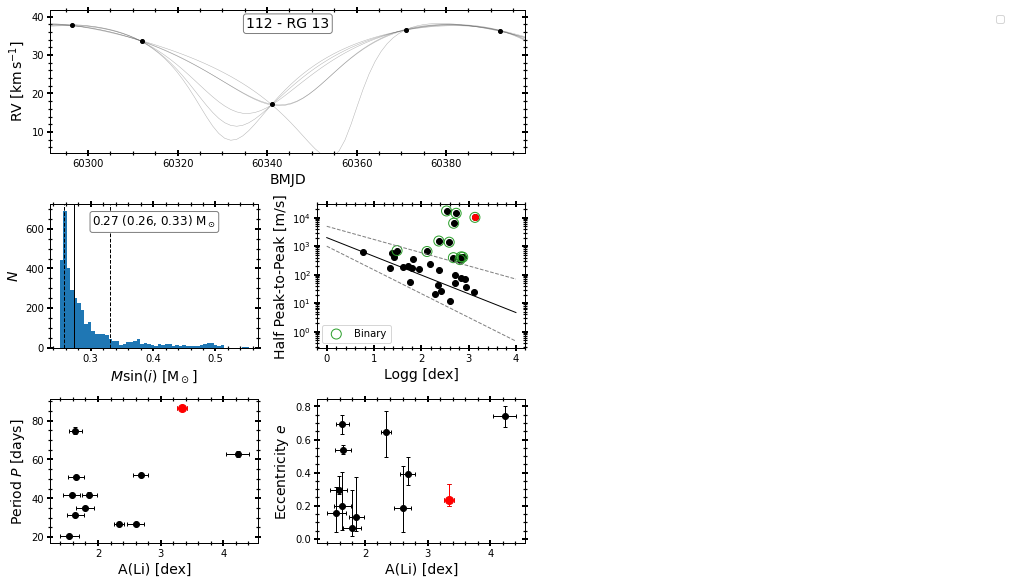

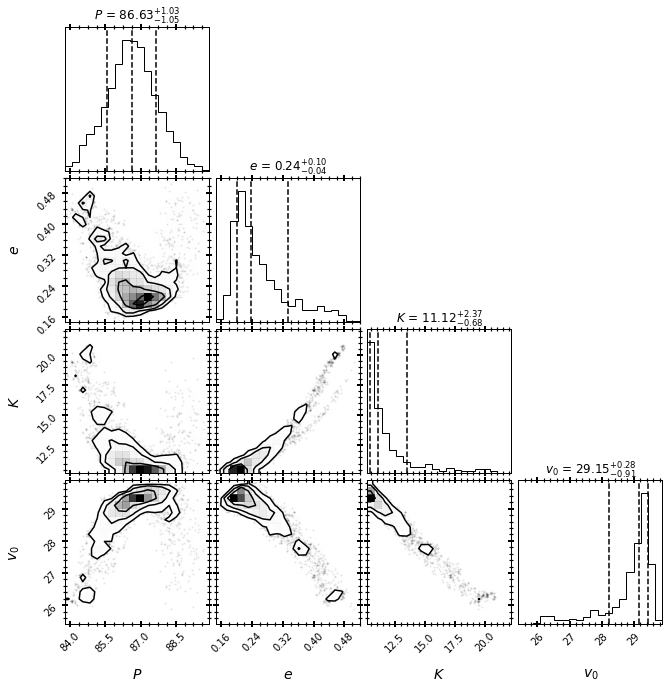

In [27]:

program = 'p112'
for RG in obj_112:
    version = p112_ver[RG]
    fig,ax1,ax2,ax3,ax4,ax5,ax6 = get_subplots()
    plot_samples(program, RG, version, obj_dir_p112, ax1)
    unit = p112_units[RG]
    plot_msini(p112_msini, RG, unit, program, ax2)
    plot_rv_logg(merged_112, RG, program, ax3)
    plot_Li_P_e(RG, program, ax4, 'P')
    plot_Li_P_e(RG, program, ax5, 'e')
    ax6.set_axis_off()
    corner_fig = corner_plot(program, RG, version)
    add_corner_plot(corner_fig, ax6, RG, program )
    add_star_info(RG, program, ax6)
    name = '../plots/diagnostic_plots/%s_%s.png'%(RG, program)
    fig.savefig(name,bbox_inches='tight',dpi=150)
    plt.close(corner_fig)
    plt.close(fig)
    
    
program = 'p113'
for RG in obj_113:
    version = p113_ver[RG]
    fig, ax1,ax2,ax3,ax4,ax5,ax6 = get_subplots()
    plot_samples(program, RG, version, obj_dir_p113, ax1)
    unit = p113_units[RG]
    plot_msini(p113_msini, RG, unit, program, ax2)
    plot_rv_logg(merged_113, RG, program, ax3)
    plot_Li_P_e(RG, program, ax4, 'P')
    plot_Li_P_e(RG, program, ax5, 'e')
    ax6.set_axis_off()
    corner_fig = corner_plot(program, RG, version)
    add_corner_plot(corner_fig, ax6, RG, program )
    add_star_info(RG, program, ax6)
    name = '../plots/diagnostic_plots/%s_%s.png'%(RG, program)
    fig.savefig(name,bbox_inches='tight',dpi=150)
    plt.close(corner_fig)
    plt.close(fig)

In [ ]:
b1 = pd.merge(merged_112['galah_id'],galah[['sobject_id','ra_dr2','dec_dr2']],right_on='sobject_id',left_on='galah_id')[['sobject_id','ra_dr2','dec_dr2']]
b2 = pd.merge(merged_113['galah_id'],galah[['sobject_id','ra_dr2','dec_dr2']],right_on='sobject_id',left_on='galah_id')[['sobject_id','ra_dr2','dec_dr2']]
pd.concat([b1,b2]).to_csv('gaia_ra_dec.csv',index=False)

In [ ]:
galah_tb = Table.read('../../lithium/data/GALAH_DR3_main_allstar_v2.fits')

In [ ]:
# pd.read_csv('../files/crossmatch_gaia_dr3.txt',delimiter='\t',header=)
gaia_dr3_crossmatch = Table.read('../files/crossmatch_gaia_dr3.fits')


In [ ]:
galah_vac_tb = Table.read('../../lithium/data/GALAH_DR3_VAC_ages_v2.fits')

In [ ]:
galah_gaia_dr3 = join(galah_tb, gaia_dr3_crossmatch, keys_left='sobject_id', keys_right='sobject_id')


In [ ]:
def compare_gaia_galah_mass(df):
    
    plt.figure(figsize=(5,4))
    df = join(df, galah_vac_tb[['sobject_id','m_act_bstep']], keys_left='sobject_id_1', keys_right='sobject_id')
    line = np.linspace(1, 8, 1000)
    plt.scatter(df['m_act_bstep'], df['Mass-Flame'])
    plt.xlabel('Galah Mass')
    plt.ylabel('Gaia Flame Mass')
    plt.tight_layout()

compare_gaia_galah_mass(galah_gaia_dr3)

In [ ]:
def gaia_abundances(df):
    lower = np.min([min(df['fe_h']), min(df['[Fe/H]'])])
    upper = np.max([max(df['fe_h']), max(df['[Fe/H]'])])
    line = np.linspace(lower, upper, 100)
    plt.figure()
    plt.scatter(df['fe_h'],df['[Fe/H]'])
    plt.plot(line, line, c='k',ls='dotted',lw=1)
    plt.xlabel('Galah DR3 FeH')
    plt.ylabel('Gaia DR3 FeH')
    print(df.keys())
    plt.tight_layout()
    
    plt.figure()
    plt.hist(df['EWHa'])
    plt.tight_layout()

gaia_abundances(galah_gaia_dr3)

In [ ]:
#pd.merge(data['sobject_id'],

In [ ]:
ss

# M/W analysis

In [ ]:
df_final = Table.read('../../lithium/final_paper_sample_09_18.csv').to_pandas()


In [ ]:
PLOT_PARAMS(LS=12,SIZE=12)
# plt.rcParams['figure.facecolor']    = 'white'
# 

In [ ]:
def get_mw(rid, ax, label):
    pid = df_final[df_final.galah_rich_id==rid].galah_poor_id.to_numpy()[0]
    rich_spectrum=get_spectra(rid,'rich',False)

    poor_spectrum=get_spectra(pid,'poor',)
    rwave_og = rich_spectrum['wave_norm_3']
    rflux_og = rich_spectrum['sob_norm_3']
    rerr     = rich_spectrum['uob_norm_3']

    pwave_og = poor_spectrum['wave_norm_3']
    pflux_og = poor_spectrum['sob_norm_3']
    perr     = poor_spectrum['uob_norm_3']

    wavelength_grid  = np.linspace(min(rwave_og),max(rwave_og),len(rwave_og))


    _,rflux = interpolate_to_grid(xdata=rwave_og, ydata=rflux_og, xgrid=wavelength_grid)
    _,pflux = interpolate_to_grid(xdata=pwave_og, ydata=pflux_og, xgrid=wavelength_grid)
    _,rerr  = interpolate_to_grid(xdata=rwave_og, ydata=rerr,  xgrid=wavelength_grid)
    _,perr  = interpolate_to_grid(xdata=pwave_og, ydata=perr,  xgrid=wavelength_grid)
    diff    = rflux-pflux
    x,dx    = 6563, 5
    x,dA  = 6563,5
    llim,ulim=x-dA,x+dA
    mask  = (wavelength_grid <= ulim) & (wavelength_grid>=llim)
    wavelength_grid = wavelength_grid[mask]
    rflux = rflux[mask]
    pflux = pflux[mask] 
    ax.plot(wavelength_grid,rflux-pflux,c='grey', lw=4, label=label)
    ax.plot(wavelength_grid,rflux-pflux,c='gold')
    ax.axvline(x,c='grey',ls='dotted',zorder=0)
    ax.axhline(0,c='grey',ls='dotted',zorder=0)
    ax.set_xlim(llim+1, ulim-1)
    #ax.legend()
    
fig = plt.figure(figsize=(12,6))
for i, row in data.iterrows():
    K, P, e, Mstar = row['K'], row['P'], row['e'], row['m_act_bstep']
    vbroad = row['vbroad']
    rid = row['galah_id']
    #print(rid)
    if i > 5: continue
    ax = plt.subplot(2,3,i+1)
    try:
        
        label = ' K = %.2f km/s \n P = %.1f days \n e = %.1f \n M$s$= %.1f $M_\odot$ \n vbr = %.1f km/s' % (K, P, e, Mstar,vbroad)
        get_mw(rid, ax, label)

        #ax.legend(fontsize=12,)
        #if i<3:
        #    ax.text(0.5, 1.01, label, fontsize=11, ha='center',va='bottom', transform = ax.transAxes)
        #else:
        
        if i == 0:
            ax.text(0.97, 0.05, label, fontsize=10, ha='right',va='bottom', transform = ax.transAxes)
        else:
            ax.text(0.97, 0.95, label, fontsize=10, ha='right',va='top', transform = ax.transAxes)
            
        if i in [0,1,2]: ax.set_ylabel('Rich - Twin')
        if i > 2: 
            ax.set_xlabel('Wavelength ['+r'$\mathrm{\AA}$'+']')
        if i in [0,1,2]:
            ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
        
    except Exception as e:
        print(e)
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig('../plots/m_vs_w_1_%s.png'%DATE,bbox_inches='tight',dpi=150)

fig = plt.figure(figsize=(12,6))
for i, row in data.iterrows():
    K, P, e, Mstar = row['K'], row['P'], row['e'], row['m_act_bstep']
    vbroad = row['vbroad']
    rid = row['galah_id']
    if i < 6: continue
    n = i-6+1
    ax = plt.subplot(2,3,n)
    try:
        label = ' K = %.2f km/s \n P = %.1f days \n e = %.1f \n M$s$= %.1f $M_\odot$ \n vbr = %.1f km/s' % (K, P, e, Mstar,vbroad)
        get_mw(rid, ax, label)
        if n==5:
            ax.text(0.03, 0.05, label, fontsize=10, ha='left',va='bottom', transform = ax.transAxes)
        else:
            ax.text(0.97, 0.95, label, fontsize=10, ha='right',va='top', transform = ax.transAxes)
            
        if i in [0,1,2]: ax.set_ylabel('Rich - Twin')
        if i > 2: 
            ax.set_xlabel('Wavelength ['+r'$\mathrm{\AA}$'+']')
        if i in [0,1,2]:
            ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
        
    except Exception as e:
        print(e)
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig('../plots/m_vs_w_2_%s.png'%DATE,bbox_inches='tight',dpi=150)
